In [1]:
# Basic utilities
import re
import sys
from datetime import date
from copy import deepcopy
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt

# Data wrangling packages
import numpy as np
from scipy import stats
from skimage.filters import threshold_yen

# Cellpose - the current belle of the ball
from cellpose import models, io

# Grab utilities from the imaging directories dir
utilsDir = re.sub(r'Cell Segmentation', 'Imaging Utilities', str(sys.path[0]))

# Homebrew utilities for importing ims files & basic image manipulation
sys.path.append(utilsDir)
import ims_file_utils as ims
import image_processing_utils as impro
from skimage.segmentation import find_boundaries

from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from skimage import io
import glob
from skimage.filters import threshold_local
from skimage.filters import threshold_li
from skimage.color import rgb2gray
from math import sqrt
from skimage.morphology import disk, ball
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.filters.rank import enhance_contrast
from skimage.exposure import adjust_gamma
import pickle as pkl
import sys
from datetime import date
import os, psutil
import re
process = psutil.Process(os.getpid())
# Grab utilities from the imaging directories dir
utilsDir = re.sub(r'Registration', 'Imaging Utilities', str(sys.path[0]))
# Homebrew utilities for importing ims files & basic image manipulation
sys.path.append(utilsDir)
#import ims_file_utils as ims
#import image_processing_utils as impro
#import plotting_funcs as plot
from functools import reduce
from scipy.spatial.distance import cdist, pdist
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries

# Use this function for local thresholding of images
def lthresh(imgstk):
    th = threshold_local(imgstk, 65, offset=0)
    imgstk = imgstk>= th
    return imgstk
# Use this function to threshold images
def thresh(imgstk):
    th = threshold_li(imgstk)
    imgstk = imgstk>= th
    return imgstk
def spotcall(img, min_sig, max_sig, nsig, th):
    blobs_log = blob_log(img, min_sigma=min_sig, max_sigma=max_sig, num_sigma=nsig, threshold=th)
    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    color = 'lime'
    title = 'Laplacian of Gaussian'
    #plt.rcParams['figure.figsize'] = [20, 15]
    #fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    #ax.set_title(title)
    #ax.imshow(img)
    #for blob in blobs_log:
    #    y, x, r = blob
    #    c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
    #    ax.add_patch(c)
    #ax.set_axis_off()
    #plt.tight_layout()
    #plt.show()
    return blobs_log


# Basic utilities
from datetime import date
from copy import deepcopy
# Data wrangling packages
from scipy import stats
from skimage.filters import threshold_yen
# Cellpose - the current belle of the ball
from cellpose import models, io
import pandas as pd
from math import sqrt

In [9]:
opdir = "/mnt/disks/external/jg4159/20230721_GFP/"
ip = opdir + 'RegisteredImages_reverse_20230721_GFP_1.pkl'
print(ip)
filehandler = open(ip, 'rb')
img_stack = pkl.load(filehandler)
filehandler.close()
runName = "20230721_GFP_1"
print(runName)

/mnt/disks/external/jg4159/20230721_GFP/RegisteredImages_reverse_20230721_GFP_6.pkl
20230721_GFP_6


In [3]:
### VARIABLE DEFINITION ###
maxpro = True # Set false if 3D registration required
interactive = False #If true will show napari visualizations
# filehandler = open(ip, 'rb')
# img_stack = pkl.load(filehandler)
# filehandler.close()

## Rescale image and set manual threshold 

In [4]:
# Order of channels
channels = ['WGA', 'GFP', 'Nuclei']

nuc_idx = [index for index, item in enumerate(channels) if re.search('Nuclei', item)][0]
mem_idx = [index for index, item in enumerate(channels) if re.search('WGA', item)][0]

print(nuc_idx, mem_idx)

2 0


In [5]:
# save tif for cellprofiler
# from tifffile import imsave
# for ch in range(4):
#     imsave(opdir+runName+'-img-R'+str(0)+'-C'+str(ch)+'.tif', max_img[:,:, ch])

In [10]:
# rescale the img stacks (R0 doesn't require rescaling)
from skimage.filters import threshold_local
from skimage.filters import threshold_li, threshold_yen, threshold_otsu
from skimage.color import rgb2gray

for img in img_stack[1:]:
    for i in range(len(img)):
        #print(np.amax(img[i]))
        img[i] *= 65535
        img[i] = img[i].astype(np.uint16)
        print(np.percentile(img[i], (97.5, 99.8)))

[122. 214.]
[132. 206.]
[416. 637.]
[122. 207.]
[125. 175.]
[459. 712.]
[151. 277.]
[133. 199.]
[505. 776.]
[118. 132.]
[164. 228.]
[227. 378.]


In [7]:
print(len(img_stack))

5


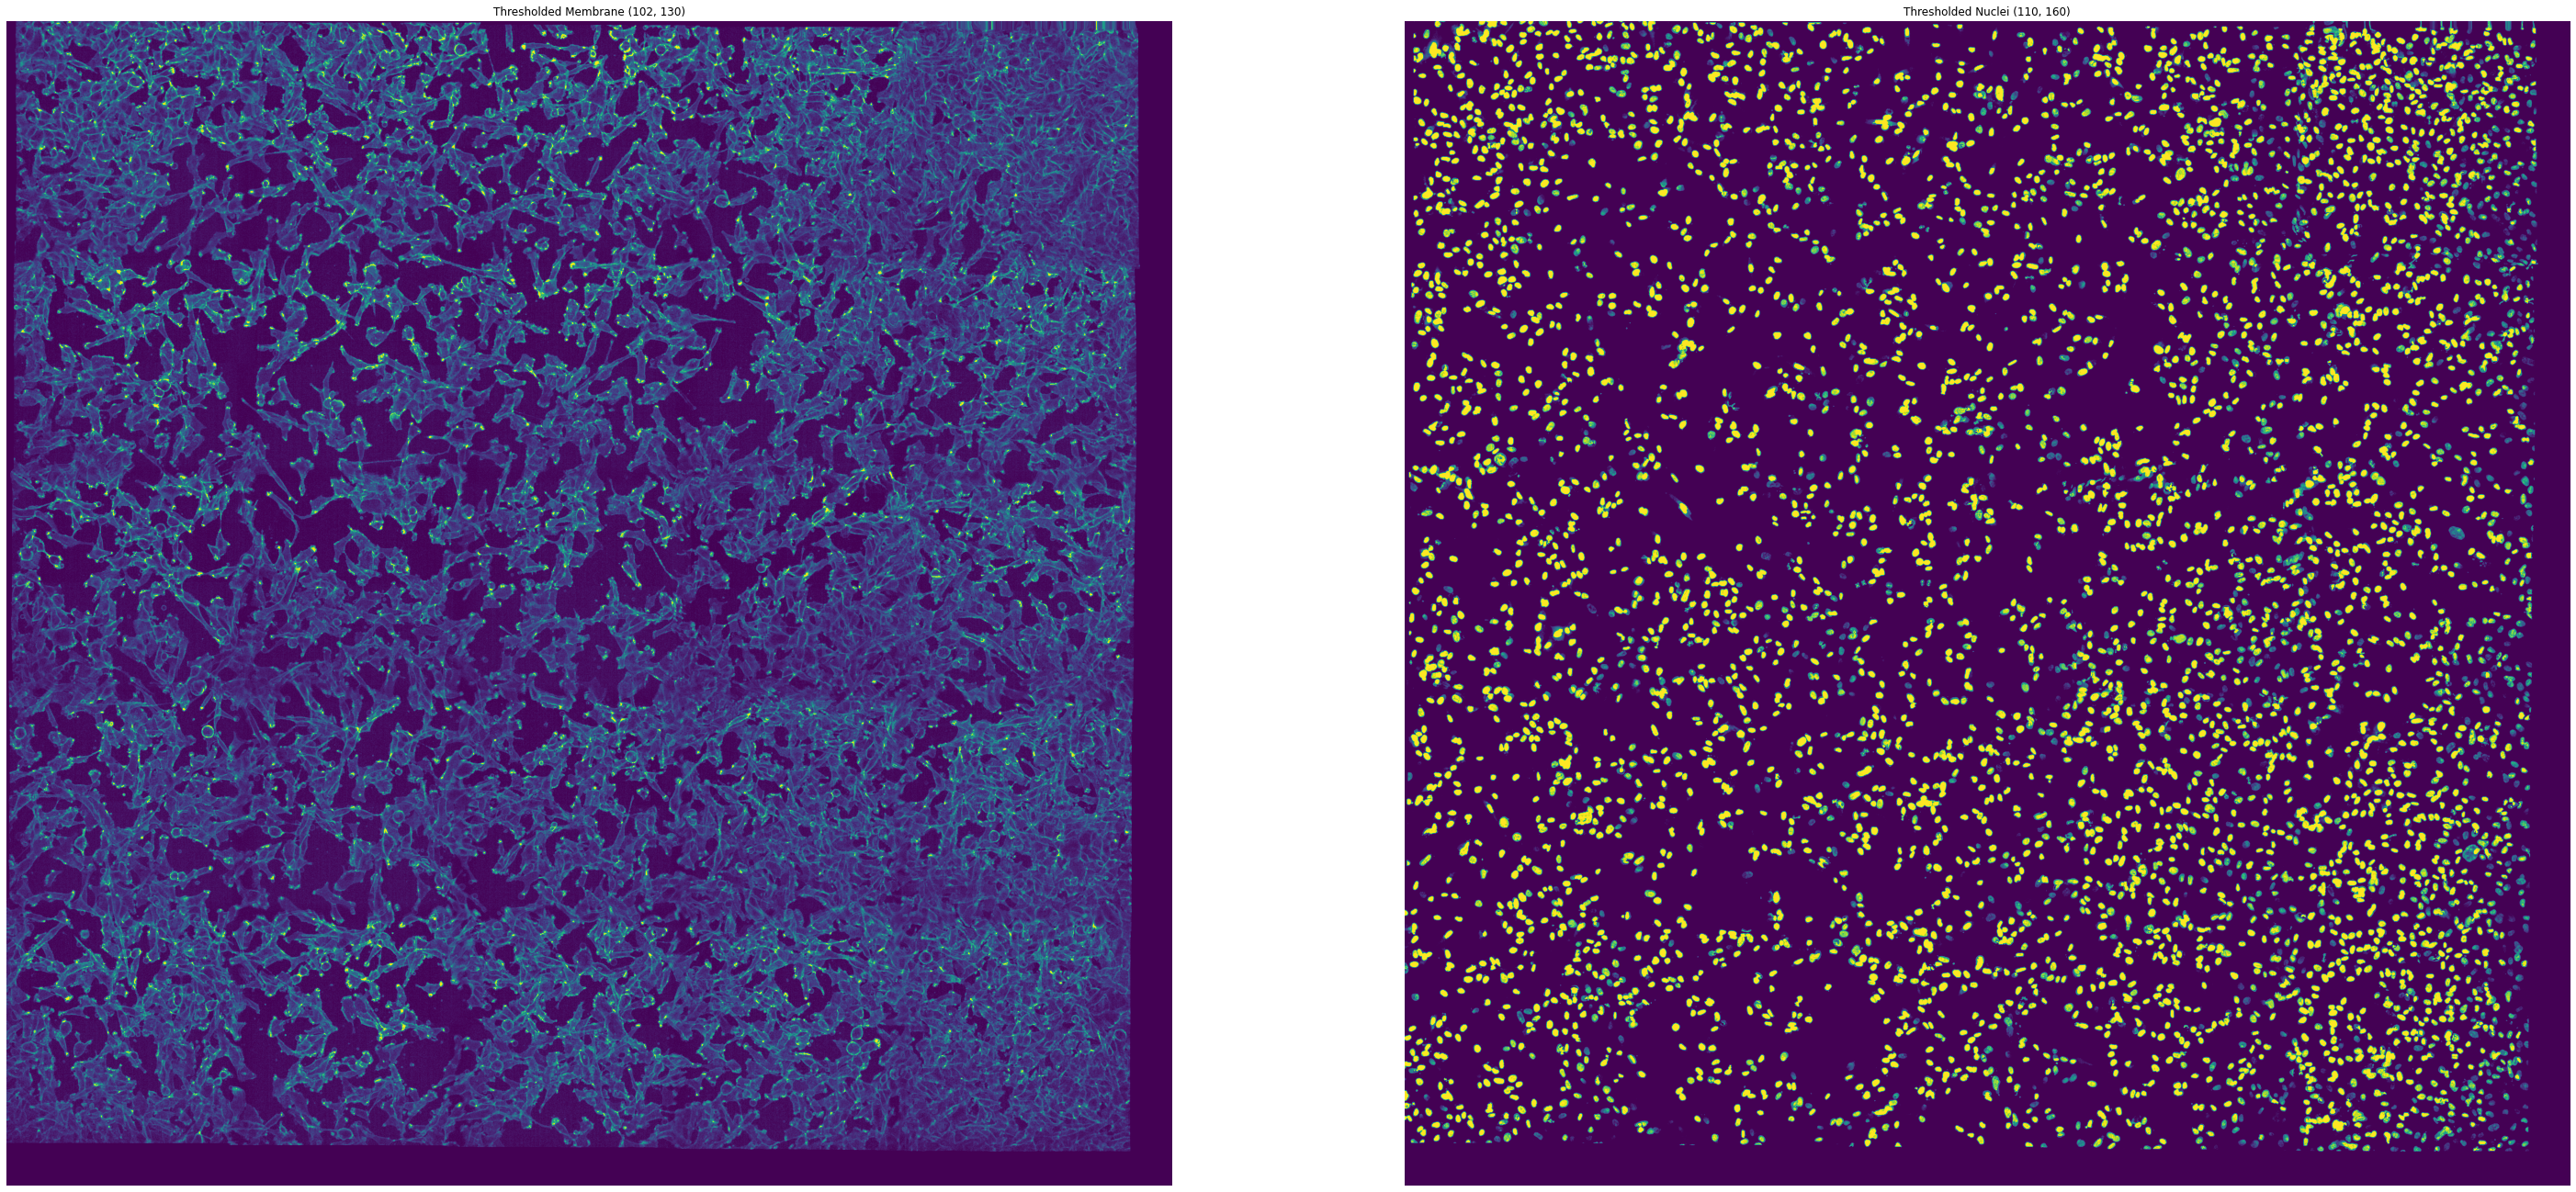

In [12]:
cell_diam = 50
# nuc and mem image thresholding
nuc_p2 = 110
nuc_p98 = 160
#file2.write(f"nuc_p2 = {nuc_p2}, nuc_p98 = {nuc_p98} \n")
mem_p2 = 102
mem_p98 = 130
#file2.write(f"mem_p2 = {mem_p2}, mem_p98 = {mem_p98} \n")
nuc = rescale_intensity(img_stack[4][2], (nuc_p2,nuc_p98), (0, 255))
mem = rescale_intensity(img_stack[4][0], (mem_p2,mem_p98), (0, 255))

plt.rcParams["figure.figsize"] = (50,50)
f, axarr = plt.subplots(1, 2)  
axarr[0].imshow(mem)
axarr[0].set_title(f"Thresholded Membrane ({mem_p2}, {mem_p98})")
axarr[0].set_axis_off()
axarr[1].imshow(nuc)
axarr[1].set_title(f"Thresholded Nuclei ({nuc_p2}, {nuc_p98})")
axarr[1].set_axis_off()

In [ ]:
# nuclei segmentation


stack_nuclei = np.stack((nuc, np.zeros(nuc.shape)), axis = 2) #nuc_idx
model = models.Cellpose(gpu=False, model_type='nuclei')
masks_nuc, flows, styles, diams = model.eval(stack_nuclei,
                                             channels=[0,0],
                                             do_3D = False,
                                             diameter = int(cell_diam/2))
# fig, ax = plt.subplots(1, 2, figsize=(45, 45))
# ax[0].imshow(nuc)
# ax[1].imshow(find_boundaries(masks_nuc))

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)


In [ ]:
cell_prob_thresh = 0.0
stack_membrane = np.stack((mem, nuc), axis = 2) # mem_idx, nuc_idx
# run Cellpose on both membranes and nuclei separately
model = models.Cellpose(gpu=False, model_type='cyto')
masks_mem, flows, styles, diams = model.eval(stack_membrane, 
                                             channels=[1,2], 
                                             do_3D = False,
                                             diameter = cell_diam, 
                                             cellprob_threshold = cell_prob_thresh, 
                                             min_size = 5)
# fig, ax = plt.subplots(1, 2, figsize=(45, 45))
# ax[0].imshow(mem)
# ax[1].imshow(find_boundaries(masks_mem))

In [ ]:
# Flatten image
flat_nuc = masks_nuc.ravel()
flat_mem = masks_mem.ravel()
# Remove the 0 (null) id since it is not a cell
nuc_ids = np.unique(flat_nuc)
nuc_ids = nuc_ids[nuc_ids!=0]
mem_ids = np.unique(flat_mem)
mem_ids = mem_ids[mem_ids!=0]
# Create the dictionary
ref_mem = dict()
for i in range(len(mem_ids)):    
    # Get Indices of Nuclei volume & append to dictionary
    mem_pxls = np.where(flat_mem==mem_ids[i])[0]
    # Get the most common membrane mask value for that location
    nucs = flat_nuc[mem_pxls]
    if sum(nucs)>0: #nuc present
        nucs = nucs[nucs!=0] #non-zero nuc_ids
        nuc_id = stats.mode(nucs)[0][0] # pick the mode as the nuc_id
        nuc_pxls = np.where(flat_nuc==nuc_id)[0]
        if len(np.unique(nucs)) > 1: #multiple nuc_id present
            second_nucs = nucs[nucs!=nuc_id] #non-zero nuc_ids
            second_nuc_id = stats.mode(second_nucs)[0][0] # pick the mode as the nuc_id
            second_nuc_pxls = np.where(flat_nuc==second_nuc_id)[0]
        else: # no other nuc_ids
            second_nuc_id = 0
            second_nuc_pxls = [0]
       # Save within a sub dictionary
        sub_dict = dict()
        sub_dict["nuc_id"] = nuc_id
        sub_dict["nuc_present"] = len(np.unique(nucs))
        sub_dict["second_nuc_id"] = second_nuc_id
        sub_dict["second_nuc_pxls"] = second_nuc_pxls
        sub_dict['Nuclei Pixels'] = nuc_pxls
        sub_dict['Membrane Pixels'] = mem_pxls
        # save the sub dictionary
        ref_mem[mem_ids[i]] = sub_dict
print(len(ref_mem))
#file2.write(f"Membrane-nuclei pairs: {len(ref_mem)} \n")

In [ ]:
f, axarr = plt.subplots(1, 2) 
axarr[0].imshow(nuc)
axarr[0].set_title(f"Thresholded Nuclei ({nuc_p2}, {nuc_p98})")
axarr[0].set_axis_off()
axarr[1].imshow(find_boundaries(masks_nuc))
axarr[1].set_title(f"Nuclei Masks ({len(np.unique(flat_nuc))} nuclei)")
axarr[1].set_axis_off()
        
#f.tight_layout()
#f.savefig(pp, format='pdf')

In [ ]:
f, axarr = plt.subplots(1, 2) 
axarr[0].imshow(mem)
axarr[0].set_title(f"Thresholded Membrane ({mem_p2}, {mem_p98})")
axarr[0].set_axis_off()
axarr[1].imshow(find_boundaries(masks_mem))
axarr[1].set_title(f"Membrane Masks ({len(np.unique(flat_mem))} membranes, {len(ref_mem)} nucleus-membrane pairs)")
axarr[1].set_axis_off()
        
#f.tight_layout()
#f.savefig(pp, format='pdf')

In [ ]:
filehandler = open(opdir+"Unfiltered_segmentation_reverse_"+runName+'.pickle', 'wb')
pkl.dump((masks_mem, masks_nuc, ref_mem), filehandler)
filehandler.close()

filehandler = open(opdir+"Unfiltered_mask_boundaries_reverse_"+runName+'.pickle', 'wb')
pkl.dump((find_boundaries(masks_nuc), find_boundaries(masks_mem)), filehandler)
filehandler.close()

In [ ]:
flat_GFP = max_img[:,:,1].ravel()
cell=0 
# Populate both dictionaries
for key in ref_mem.keys(): 
    if cell%1000==0:
        print(cell)
    cell=cell+1
    if True:
        mem_pxls = ref_mem[key]['Membrane Pixels']
        nuc_pxls = ref_mem[key]['Nuclei Pixels']
        
        # Save within a sub dictionary
        sub_dict1 = dict()
        # Get GFP Stats
        sum_GFP_nuc = np.sum(flat_GFP[nuc_pxls])
        sum_GFP_mem = np.sum(flat_GFP[mem_pxls])
        sub_dict1['Sum GFP under Nuclei'] = sum_GFP_nuc
        sub_dict1['Avg GFP under Nuclei'] = sum_GFP_nuc/len(nuc_pxls)
        sub_dict1['Sum GFP under Membrane'] = sum_GFP_mem
        sub_dict1['Avg GFP under Membrane'] = sum_GFP_mem/len(mem_pxls)

        # save the sub dictionary
        ref_mem[key].update(sub_dict1)

In [ ]:
# optional plotting of GFP
import matplotlib.pyplot as plt
import numpy as np
import plotting_funcs_BEpilot as plot
ids = ref_mem.keys()
plot.gfpDistribution(ref_mem, 
                    avgRange = (min([ref_mem[idx]['Avg GFP under Membrane'] for idx in ids]),
                                     max([ref_mem[idx]['Avg GFP under Membrane'] for idx in ids])), 
                    sumRange = (min([ref_mem[idx]['Sum GFP under Membrane'] for idx in ids]),
                                     max([ref_mem[idx]['Sum GFP under Membrane'] for idx in ids])), name = "GFP")
    
# Plot cell size distribution just to make sure there isnt anything funky going on - should see a normal distribution
plot.cellSizeDistribution(ref_mem)
plt.show()

In [ ]:
data = []
for key in ref_mem.keys(): # use keys in the saved dict
    data.append([key, ref_mem[key]['Avg GFP under Membrane'], ref_mem[key]['Avg GFP under Nuclei'], len(ref_mem[key]['Nuclei Pixels']), len(ref_mem[key]['Membrane Pixels'])])

df2 = pd.DataFrame(data, columns=['cell_id', 'avg_GFP_mem', 'avg_GFP_nuc', "nuclei_size", "mem_size"])
df2 = df2.sort_values(by="cell_id")
df2

In [ ]:
df2.to_csv(opdir + runName + "_reverse"  + '.csv', index=False)